In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()
from pathlib import Path
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from datasets import synth_dataset 
import visualisations
from visualisations import visualise_data, visualise_model

--- 

# Hybrids

In [23]:
params = {"model_name":"RSAE",
          "model_version":"standardS",
          "data" : "MNIST"}

In [26]:
# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/RSAE/standardS.yaml
RSAE model hanlder loaded.
Loading latest checkpoint at logs\RSAE\standardS_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
           

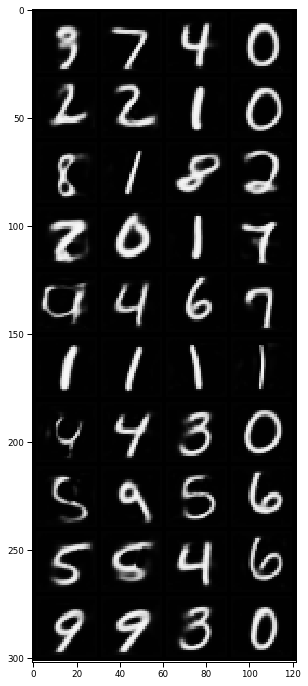

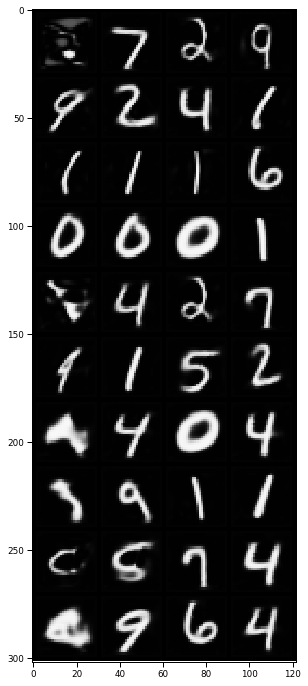

In [30]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_hybrisation=True, first=False)
fig = res['hybrids']
fname = fig_path / ("hybridsLow"+params["model_name"]+".png")
fig.savefig(fname)

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_hybrisation=True, first=True)
fig = res['hybrids']
fname = fig_path / ("hybridsHigh"+params["model_name"]+".png")
fig.savefig(fname)

# Distortion

In [32]:
params = {"model_name":"RSAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/RSAE/standardS.yaml
RSAE model hanlder loaded.
Loading latest checkpoint at logs\RSAE\standardS_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
           

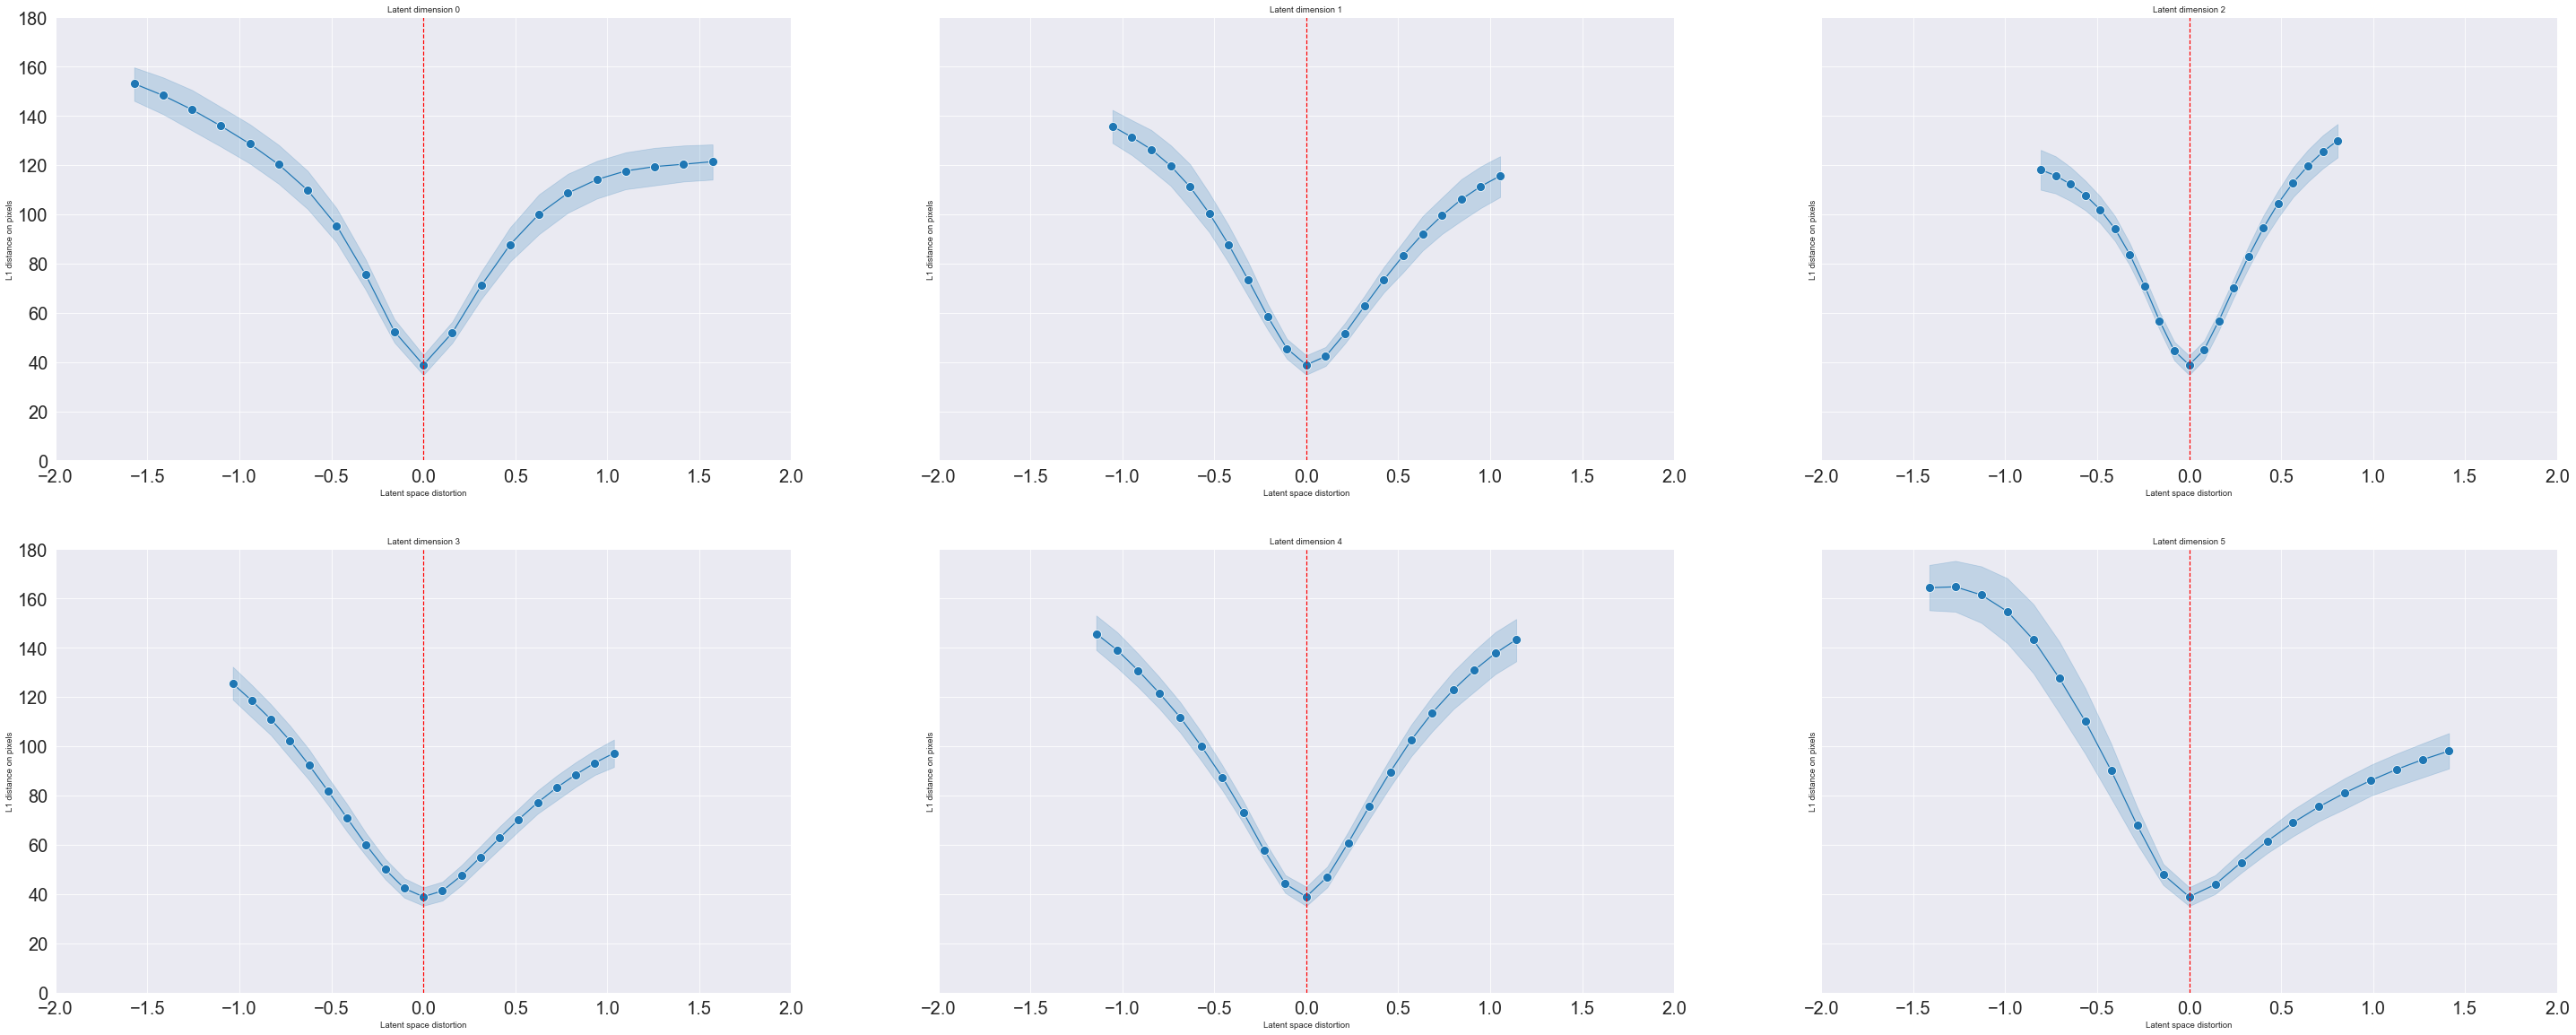

In [34]:
figure_params = {"figsize":(50,20),
                "nrow":2, 
                "ylim":180, 
                "xlim":2
                }

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=True, **figure_params)
fig = res['distortion']
fname = fig_path / ("distortion"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

# Latent Response

In [2]:
params = {"model_name":"VecRSAE",
          "model_version":"standard",
          "data_version":"standard",
          "data" : "SynthVec"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"

----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecRSAE model hanlder loaded.


In [3]:
LR = handler.latent_responses(load=True).cpu()

Loading latent response matrix


figures\responsesVecRSAE.png saved


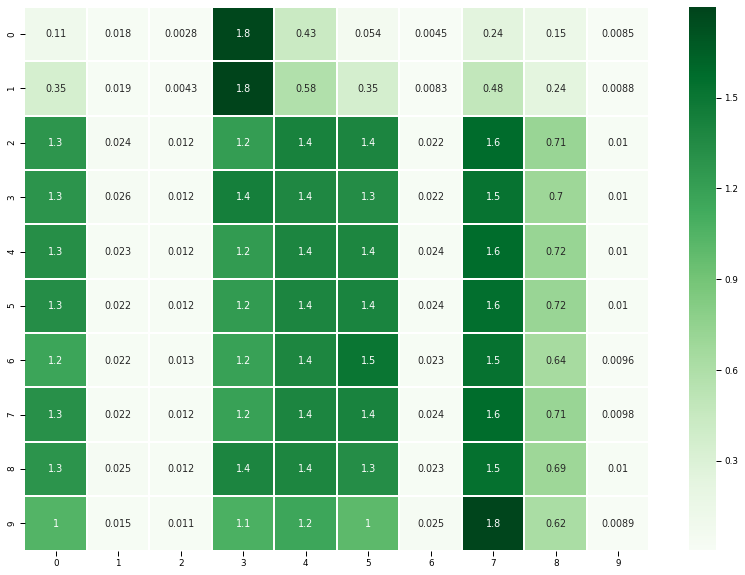

In [4]:
#https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb
fig = plt.figure(figsize=(14,10))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(LR, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("responses"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

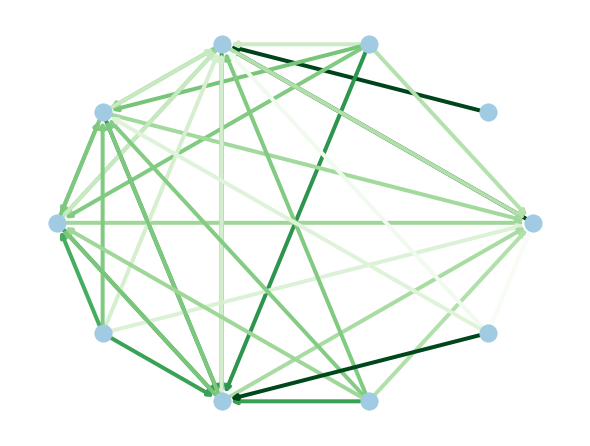

figures\latent_graphVecRSAE.png saved


In [10]:
threshold = 1.0
num_bins = 100
graph_adj = torch.max(LR-threshold,torch.zeros_like(LR))
G = nx.from_numpy_matrix(np.matrix(graph_adj), create_using=nx.DiGraph)
pos = nx.circular_layout(G)
edges = G.edges()
weights = [graph_adj[u][v] for u,v in edges]
weights = np.digitize(weights, np.histogram(weights, num_bins)[1][:-1])

options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": False,
    "font_color": "white",
}


fig = plt.figure(figsize=(8,6))
nx.draw(G, pos=pos, **options)
plt.show()
fname = fig_path / ("latent_graph"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

figures\standardVec_graph.png saved


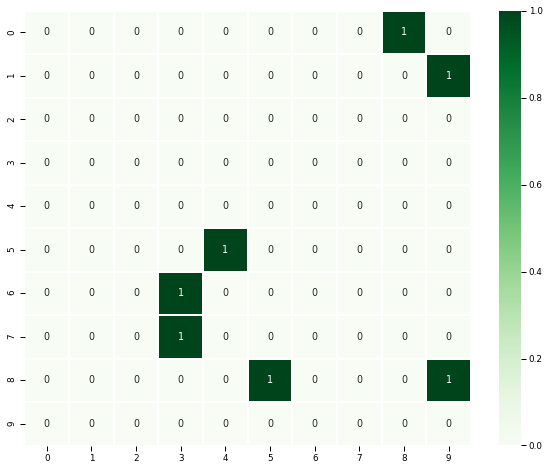

In [21]:
true_matrix = handler.dataloader.train.dataset.dataset.get_graph_matrix()
fig = plt.figure(figsize=(10,8))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(true_matrix, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("standardVec_graph.png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")